In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [3]:
rainfall_df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_dataset.csv')
rainfall_df

,DISTRICTS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,BAGALKOTE,2008,0.0,16.7,94.2,10.3,37.5,46.5,28.3,60.2,135.4,60.3,27.2,0.3
1,BAGALKOTE,2009,0.0,0.0,2.9,14.8,66.3,119.0,41.7,107.3,195.6,220.1,28.8,31.2
2,BAGALKOTE,2010,13.4,0.1,0.0,10.6,57.4,109.7,89.6,149.3,64.2,58.3,83.2,0.4
3,BAGALKOTE,2011,0.0,1.9,0.4,39.2,81.0,74.9,77.6,107.0,57.1,90.4,0.0,0.0
4,BENGALURU RURAL,2008,0.0,2.1,100.9,15.2,100.7,11.8,149.1,223.0,103.9,150.4,25.2,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,YADGIR,2019,0.0,0.0,0.0,15.7,21.9,82.5,138.2,70.7,181.1,67.4,11.2,0.9
353,MYSURU,2020,0.0,4.3,19.9,50.0,128.4,72.7,124.2,138.5,140.4,97.1,36.0,14.7
354,HASSAN,2020,0.2,0.0,13.2,47.2,161.0,111.3,177.3,225.0,175.9,155.4,26.9,16.4
355,KODAGU,2020,0.0,0.0,16.3,113.2,201.8,412.2,436.9,974.9,521.1,178.7,24.1,9.9


In [4]:
departure_df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
departure_df

,DISTRICTS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,BAGALKOTE,2008,-100.0,882.0,1677.0,-57.0,-35.0,-37.0,-63.0,-16.0,-7.0,-41.0,-2.0,-95.0
1,BAGALKOTE,2009,-100.0,-100.0,-45.0,-38.0,14.0,62.0,-45.0,50.0,35.0,116.0,4.0,380.0
2,BAGALKOTE,2010,1118.0,-94.0,-100.0,-56.0,-1.0,50.0,18.0,109.0,-56.0,-43.0,200.0,-94.0
3,BAGALKOTE,2011,-100.0,27.0,-91.0,67.0,41.0,-6.0,5.0,48.0,-58.0,-20.0,-100.0,-100.0
4,BAGALKOTE,2012,-100.0,-99.0,-100.0,36.0,-69.0,-59.0,-26.0,-6.0,-64.0,-17.0,65.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,HASSAN,2020,-88.0,-100.0,-4.0,-7.0,70.0,-23.0,-21.0,29.0,33.0,1.0,-47.0,89.0
330,KODAGU,2019,-100.0,-64.0,-66.0,-19.0,-57.0,-49.0,-35.0,120.0,114.0,51.0,-32.0,76.0
331,KODAGU,2020,-100.0,-100.0,-30.0,34.0,38.0,-28.0,-50.0,66.0,126.0,-14.0,-69.0,-50.0
332,CHIKKAMAGALURU,2019,-100.0,176.0,-46.0,-36.0,-48.0,-45.0,-18.0,126.0,119.0,163.0,-63.0,227.0


In [5]:
rainfall_df = rainfall_df.melt(id_vars=['DISTRICTS', 'YEAR'], var_name='MONTH', value_name='RAINFALL')
rainfall_df

,DISTRICTS,YEAR,MONTH,RAINFALL
0,BAGALKOTE,2008,JAN,0.0
1,BAGALKOTE,2009,JAN,0.0
2,BAGALKOTE,2010,JAN,13.4
3,BAGALKOTE,2011,JAN,0.0
4,BENGALURU RURAL,2008,JAN,0.0
...,...,...,...,...
4279,YADGIR,2019,DEC,0.9
4280,MYSURU,2020,DEC,14.7
4281,HASSAN,2020,DEC,16.4
4282,KODAGU,2020,DEC,9.9


In [6]:
departure_df = departure_df.melt(id_vars=['DISTRICTS', 'YEAR'], var_name='MONTH', value_name='DEPARTURE')
departure_df

,DISTRICTS,YEAR,MONTH,DEPARTURE
0,BAGALKOTE,2008,JAN,-100.0
1,BAGALKOTE,2009,JAN,-100.0
2,BAGALKOTE,2010,JAN,1118.0
3,BAGALKOTE,2011,JAN,-100.0
4,BAGALKOTE,2012,JAN,-100.0
...,...,...,...,...
4003,HASSAN,2020,DEC,89.0
4004,KODAGU,2019,DEC,76.0
4005,KODAGU,2020,DEC,-50.0
4006,CHIKKAMAGALURU,2019,DEC,227.0


In [7]:
rainfall_df = rainfall_df[rainfall_df['DISTRICTS'] == 'KODAGU']
departure_df = departure_df[departure_df['DISTRICTS'] == 'KODAGU']
rainfall_df

,DISTRICTS,YEAR,MONTH,RAINFALL
70,KODAGU,2008,JAN,0.0
71,KODAGU,2009,JAN,0.0
72,KODAGU,2010,JAN,12.4
73,KODAGU,2011,JAN,0.7
131,KODAGU,2012,JAN,0.5
...,...,...,...,...
4177,KODAGU,2016,DEC,49.9
4207,KODAGU,2017,DEC,23.8
4237,KODAGU,2018,DEC,8.2
4267,KODAGU,2019,DEC,34.7


In [8]:
rainfall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 70 to 4282
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DISTRICTS  156 non-null    object 
 1   YEAR       156 non-null    int64  
 2   MONTH      156 non-null    object 
 3   RAINFALL   156 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ KB


In [9]:
month_le = LabelEncoder().fit(rainfall_df['MONTH'])
print(month_le.classes_)

['APR' 'AUG' 'DEC' 'FEB' 'JAN' 'JUL' 'JUN' 'MAR' 'MAY' 'NOV' 'OCT' 'SEP']


In [29]:
season_dict = {'JAN': 'WINTER', 'FEB': 'WINTER', 'MAR': 'SUMMER', 'APR': 'SUMMER',
               'MAY': 'SUMMER', 'JUN': 'SUMMER', 'JUL': 'MONSOON', 'AUG': 'MONSOON',
               'SEP': 'MONSOON', 'OCT': 'WINTER', 'NOV': 'WINTER', 'DEC': 'WINTER'}
season_le = LabelEncoder().fit(np.array(list(season_dict.values())))
print(season_le.classes_)

['MONSOON' 'SUMMER' 'WINTER']


In [220]:
class CustomDataset(Dataset):
    def __init__(self, data_type, rainfall_df, departure_df, month_le, season_le):
        self.rainfall_df = rainfall_df.copy()
        self.departure_df = departure_df.copy()
        if data_type == 'train':
            self.year_month = self.rainfall_df[(self.rainfall_df['YEAR'] >= 2011) & (self.rainfall_df['YEAR'] < 2019)][['YEAR', 'MONTH']].drop_duplicates().values
        elif data_type == 'val':
            self.year_month = self.rainfall_df[self.rainfall_df['YEAR'] >= 2019][['YEAR', 'MONTH']].drop_duplicates().values
        self.month_le = month_le
        self.season_le = season_le
    
    def __getitem__(self, index):
        year, month = self.year_month[index]
        districts, year, month, rainfall = self.rainfall_df[(self.rainfall_df['YEAR'] == year) & (self.rainfall_df['MONTH'] == month)].values[0]
        prev_avg_rainfall = self.rainfall_df[(self.rainfall_df['YEAR'] < year) & (self.rainfall_df['MONTH'] == month)].sort_values('YEAR', ascending=False)['RAINFALL'].values[:3].mean()
        prev_avg_departure = self.departure_df[(self.departure_df['MONTH'] == month) & (self.departure_df['YEAR'] < year)].sort_values('YEAR', ascending=False)['DEPARTURE'].values[:3].mean()
        print(self.rainfall_df[(self.rainfall_df['YEAR'] < year) & (self.rainfall_df['MONTH'] == month)].sort_values('YEAR', ascending=False))

        season = season_le.transform([season_dict[month]])[0]

        if (year % 4) == 0:
            if (year % 100) == 0:
                if (year % 400) == 0:
                    is_leap = 1
                else:
                    is_leap = 0
            else:
                is_leap = 1
        else:
            is_leap = 0
        
        month = self.month_le.transform([month])[0]
        return (month, is_leap, season, torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), rainfall
    
    def __len__(self):
        return len(self.year_month)

In [221]:
train_df = rainfall_df[rainfall_df['YEAR'] < 2019]
val_df = rainfall_df[rainfall_df['YEAR'] >= 2019]

train_df.shape, val_df.shape

((132, 4), (24, 4))

In [222]:
train_ds = CustomDataset('train', rainfall_df, departure_df, month_le, season_le)
val_ds = CustomDataset('val', rainfall_df, departure_df, month_le, season_le)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=24)

In [223]:
for x, y in train_ds:
    # print(x)
    pass

   DISTRICTS  YEAR MONTH  RAINFALL
72    KODAGU  2010   JAN      12.4
71    KODAGU  2009   JAN       0.0
70    KODAGU  2008   JAN       0.0
   DISTRICTS  YEAR MONTH  RAINFALL
73    KODAGU  2011   JAN       0.7
72    KODAGU  2010   JAN      12.4
71    KODAGU  2009   JAN       0.0
70    KODAGU  2008   JAN       0.0
    DISTRICTS  YEAR MONTH  RAINFALL
131    KODAGU  2012   JAN       0.5
73     KODAGU  2011   JAN       0.7
72     KODAGU  2010   JAN      12.4
71     KODAGU  2009   JAN       0.0
70     KODAGU  2008   JAN       0.0
    DISTRICTS  YEAR MONTH  RAINFALL
161    KODAGU  2013   JAN       0.0
131    KODAGU  2012   JAN       0.5
73     KODAGU  2011   JAN       0.7
72     KODAGU  2010   JAN      12.4
71     KODAGU  2009   JAN       0.0
70     KODAGU  2008   JAN       0.0
    DISTRICTS  YEAR MONTH  RAINFALL
191    KODAGU  2014   JAN       3.3
161    KODAGU  2013   JAN       0.0
131    KODAGU  2012   JAN       0.5
73     KODAGU  2011   JAN       0.7
72     KODAGU  2010   JAN      12.4
7

In [217]:
class RainPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.month_emb = nn.Embedding(num_embeddings=12, embedding_dim=24)
        self.leap_emb = nn.Embedding(num_embeddings=2, embedding_dim=4)
        self.season_emb = nn.Embedding(num_embeddings=3, embedding_dim=64)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=4),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=96, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    
    def forward(self, x_month, x_leap, x_season, x_prev_data):
        month_out = self.month_emb(x_month)
        leap_out = self.leap_emb(x_leap)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        out = torch.cat([month_out, leap_out, season_out, prev_data_out], axis=-1)
        return self.output(out)

In [209]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0]#.cuda()
            x_leap = xb[1]#.cuda()
            x_season = xb[2]#.cuda()
            x_prev_data = xb[3]#.cuda()
            yb = yb.float()#.cuda()

            y_hat = model(x_month, x_leap, x_season, x_prev_data)
            loss = criterion(y_hat, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0]#.cuda()
                x_leap = xb[1]#.cuda()
                x_season = xb[2]#.cuda()
                x_prev_data = xb[3]#.cuda()
                yb = yb#.cuda()

                y_hat = model(x_month, x_leap, x_season, x_prev_data)
                loss = criterion(y_hat, yb)

                val_loss += loss.item()
                
        print(f'Epoch - {epoch+1} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [210]:
model = RainPredictionModel()

In [211]:
train(model, epochs=20, lr=1e-03)

Epoch - 1 | Train Loss - 123574.99 | Val Loss - 157291.75
Epoch - 2 | Train Loss - 106404.65 | Val Loss - 129143.98
Epoch - 3 | Train Loss - 84693.49 | Val Loss - 127078.55
Epoch - 4 | Train Loss - 84980.15 | Val Loss - 119432.06
Epoch - 5 | Train Loss - 84023.21 | Val Loss - 117249.34
Epoch - 6 | Train Loss - 80105.38 | Val Loss - 117155.48
Epoch - 7 | Train Loss - 81898.44 | Val Loss - 116473.97
Epoch - 8 | Train Loss - 81722.6 | Val Loss - 115035.72
Epoch - 9 | Train Loss - 81854.62 | Val Loss - 113970.88
Epoch - 10 | Train Loss - 80832.34 | Val Loss - 115188.97
Epoch - 11 | Train Loss - 81911.98 | Val Loss - 112238.23
Epoch - 12 | Train Loss - 81103.45 | Val Loss - 112714.29
Epoch - 13 | Train Loss - 78841.62 | Val Loss - 115436.86
Epoch - 14 | Train Loss - 78304.07 | Val Loss - 117667.5
Epoch - 15 | Train Loss - 80804.79 | Val Loss - 116628.11
Epoch - 16 | Train Loss - 79481.21 | Val Loss - 115669.27
Epoch - 17 | Train Loss - 81566.95 | Val Loss - 113620.09
Epoch - 18 | Train Loss

In [212]:
train(model, epochs=20, lr=1e-04)

Epoch - 1 | Train Loss - 80443.67 | Val Loss - 111098.16
Epoch - 2 | Train Loss - 80990.16 | Val Loss - 111185.61
Epoch - 3 | Train Loss - 79027.04 | Val Loss - 111301.3
Epoch - 4 | Train Loss - 80942.66 | Val Loss - 111486.0
Epoch - 5 | Train Loss - 79598.87 | Val Loss - 111654.04
Epoch - 6 | Train Loss - 79430.28 | Val Loss - 111814.57
Epoch - 7 | Train Loss - 79251.98 | Val Loss - 112079.28
Epoch - 8 | Train Loss - 79688.98 | Val Loss - 112154.75
Epoch - 9 | Train Loss - 77847.21 | Val Loss - 112337.89
Epoch - 10 | Train Loss - 80306.79 | Val Loss - 112506.59
Epoch - 11 | Train Loss - 78920.58 | Val Loss - 112726.92
Epoch - 12 | Train Loss - 79368.18 | Val Loss - 112822.81
Epoch - 13 | Train Loss - 78880.76 | Val Loss - 112975.42
Epoch - 14 | Train Loss - 80201.72 | Val Loss - 112944.52
Epoch - 15 | Train Loss - 76528.76 | Val Loss - 113147.7
Epoch - 16 | Train Loss - 80209.08 | Val Loss - 113282.27
Epoch - 17 | Train Loss - 77583.18 | Val Loss - 113436.99
Epoch - 18 | Train Loss - 

In [213]:
train(model, epochs=20, lr=1e-05)

Epoch - 1 | Train Loss - 80084.66 | Val Loss - 113679.39
Epoch - 2 | Train Loss - 74426.1 | Val Loss - 113716.77
Epoch - 3 | Train Loss - 79216.13 | Val Loss - 113735.01
Epoch - 4 | Train Loss - 80992.93 | Val Loss - 113729.3
Epoch - 5 | Train Loss - 78575.86 | Val Loss - 113736.77
Epoch - 6 | Train Loss - 77143.16 | Val Loss - 113765.76
Epoch - 7 | Train Loss - 79031.47 | Val Loss - 113773.11
Epoch - 8 | Train Loss - 79454.3 | Val Loss - 113772.02
Epoch - 9 | Train Loss - 75688.17 | Val Loss - 113793.71
Epoch - 10 | Train Loss - 77287.61 | Val Loss - 113835.42
Epoch - 11 | Train Loss - 79871.44 | Val Loss - 113833.23
Epoch - 12 | Train Loss - 78369.28 | Val Loss - 113847.11
Epoch - 13 | Train Loss - 80865.77 | Val Loss - 113831.86
Epoch - 14 | Train Loss - 78963.13 | Val Loss - 113834.04
Epoch - 15 | Train Loss - 78950.0 | Val Loss - 113843.27
Epoch - 16 | Train Loss - 76731.09 | Val Loss - 113855.95
Epoch - 17 | Train Loss - 81492.06 | Val Loss - 113843.19
Epoch - 18 | Train Loss - 7

In [ ]:
mod_df['y'] = mod_df['y'].astype(float)
mod_df['ds'] = mod_df['ds'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m'))
mod_df.head()

,ds,y
0,2011-01-01,0.7
1,2011-02-01,22.2
2,2011-03-01,13.2
3,2011-04-01,138.5
4,2011-05-01,107.5


In [ ]:
train_df = mod_df[mod_df['ds'] < '2019-01']
test_df = mod_df[mod_df['ds'] >= '2019-01']

train_df.shape, test_df.shape

((96, 2), (24, 2))

In [ ]:
def ad_test(ser):
    dftest = adfuller(ser)
    print('ADF :', dftest[0])
    print('P-Value :', dftest[1])
    print('Num of Lags :', dftest[2])
    print('Num of Observations used for ADF Regression and Critical Value calculations :', dftest[3])
    print('Critical Values :')
    for k, v in dftest[4].items():
        print('\t', k, ':', v)

In [ ]:
ad_test(train_df['y'])

ADF : -1.3289545419689566
P-Value : 0.615823695229007
Num of Lags : 11
Num of Observations used for ADF Regression and Critical Value calculations : 84
Critical Values :
	 1% : -3.510711795769895
	 5% : -2.8966159448223734
	 10% : -2.5854823866213152


In [ ]:
train_df['Rainfall First Difference'] = train_df['y'] - train_df['y'].shift(1)
train_df['Seasonal First Difference'] = train_df['y'] - train_df['y'].shift(12)
train_df.head()

,ds,y,Rainfall First Difference,Seasonal First Difference
0,2011-01-01,0.7,NaN,NaN
1,2011-02-01,22.2,21.5,NaN
2,2011-03-01,13.2,-9.0,NaN
3,2011-04-01,138.5,125.3,NaN
4,2011-05-01,107.5,-31.0,NaN


In [ ]:
ad_test(train_df['Rainfall First Difference'].dropna())

ADF : -8.314367651317372
P-Value : 3.714986041431088e-13
Num of Lags : 10
Num of Observations used for ADF Regression and Critical Value calculations : 84
Critical Values :
	 1% : -3.510711795769895
	 5% : -2.8966159448223734
	 10% : -2.5854823866213152


In [ ]:
ad_test(train_df['Seasonal First Difference'].dropna())

ADF : -6.737283780255707
P-Value : 3.1838020162998003e-09
Num of Lags : 0
Num of Observations used for ADF Regression and Critical Value calculations : 83
Critical Values :
	 1% : -3.5117123057187376
	 5% : -2.8970475206326833
	 10% : -2.5857126912469153


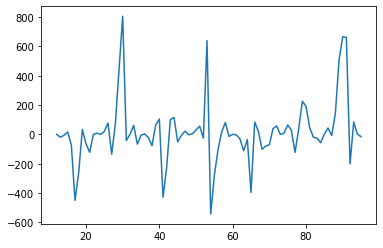

In [ ]:
train_df['Seasonal First Difference'].plot()

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

In [ ]:
stepwise_fit = auto_arima(mod_df['y'], max_p=20, max_d=20, max_q=20,
                          max_P=20, max_D=20, max_Q=20, m=12, stepwise=False,
                          max_order=10, n_fits=50, n_jobs=-1, out_of_sample_size=24, trace=True)
stepwise_fit.summary()

KeyboardInterrupt: ignored

In [ ]:
import itertools
from tqdm.notebook import tqdm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [ ]:
p = range(15)
q = range(15)
d = range(2)

In [ ]:
pdq_cmb_list = list(itertools.product(p,d,q))
seasonal_pdq_cmb_list = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
pdq_cmb_list[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]

In [ ]:
order = []
mse_error = []
for pdq in tqdm(pdq_cmb_list):
    for s_pdq in tqdm(seasonal_pdq_cmb_list, leave=False):
        try:
            model = SARIMAX(train_df['y'], order=pdq, seasonal_order=s_pdq, enforce_stationarity=False, enforce_invertibility=False).fit()
            pred = model.predict(train_df['y'].shape[0], train_df['y'].shape[0]+23)
            error = mean_squared_error(test_df['y'], pred)
            order.append((pdq, s_pdq))
            mse_error.append(error)
        except:
            continue

In [ ]:
min_error = min(mse_error)
min_error_index = mse_error.index(min_error)
best_pdq = order[min_error_index]
best_pdq

(6, 0, 3)

In [ ]:
model = ARIMA(train_df['y'], order=best_pdq)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:                     ARMA(6, 3)   Log Likelihood                -630.640
Method:                       css-mle   S.D. of innovations            164.714
Date:                Wed, 30 Jun 2021   AIC                           1283.281
Time:                        04:42:31   BIC                           1311.489
Sample:                             0   HQIC                          1294.683
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        214.4473     17.698     12.117      0.000     179.760     249.134
ar.L1.y        1.0993      0.001   1431.523      0.000       1.098       1.101
ar.L2.y        0.2590      0.000    542.289      0.000       0.258       0.260
ar.L3.y       -1.3159      0.000  -3454.396      0.000      -1.317      -1.315
ar.L4.y        0.6601      0.002    414.463      0.000       0.657       0.663
ar.L5.y       -0.0600      0.001    -83.959      0.000      -0.061      -0.059
ar.L6.y       -0.1958      0.002   -120.130      0.000      -0.199      -0.193
ma.L1.y       -0.7117      0.048    -14.837      0.000      -0.806      -0.618
ma.L2.y       -0.7106      0.018    -39.511      0.000      -0.746      -0.675
ma.L3.y        0.9996      0.052     19.124      0.000       0.897       1.102
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           -0.0000j            1.0000           -0.5000
AR.2            0.8661           -0.5005j            1.0004           -0.0834
AR.3            0.8661           +0.5005j            1.0004            0.0834
AR.4            0.7584           -1.1924j            1.4132           -0.1598
AR.5            0.7584           +1.1924j            1.4132            0.1598
AR.6           -2.5556           -0.0000j            2.5556           -0.5000
MA.1           -1.0004           -0.0000j            1.0004           -0.5000
MA.2            0.8556           -0.5176j            1.0000           -0.0866
MA.3            0.8556           +0.5176j            1.0000            0.0866
-----------------------------------------------------------------------------
"""

In [ ]:
pred = model.predict(start=train_df.shape[0], end=train_df.shape[0]+23)
pred

96     -54.023814
97     -47.515353
98       3.546473
99     151.692858
100    309.975055
101    464.290639
102    525.473135
103    517.870452
104    407.896221
105    267.890643
106     95.646808
107    -24.145907
108   -100.327682
109    -72.777054
110     11.643031
111    170.494924
112    321.349235
113    463.444933
114    518.675242
115    512.084211
116    405.682867
117    267.981896
118     96.123974
119    -23.931424
dtype: float64

In [ ]:
pred = pred - pred.min()
pred

96      46.303868
97      52.812329
98     103.874155
99     252.020540
100    410.302737
101    564.618321
102    625.800817
103    618.198134
104    508.223903
105    368.218325
106    195.974491
107     76.181775
108      0.000000
109     27.550628
110    111.970713
111    270.822606
112    421.676917
113    563.772615
114    619.002924
115    612.411893
116    506.010549
117    368.309578
118    196.451656
119     76.396258
dtype: float64

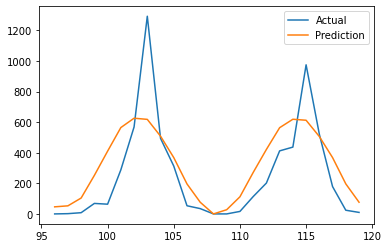

In [ ]:
plt.plot(test_df['y'], label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()